---
---

### This notebook contains exploratory data analysis built over multiple iterations. While the structure isn't perfectly linear, it provides useful insights into feature engineering and design choices. See the EDAV report for a formal analysis.
---
---

In [2]:

import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.config.set_backend("torch")
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Keras backend:", keras.backend.backend())
print("PyTorch CUDA available:", torch.cuda.is_available())
print("Selected device:", device)


Keras backend: torch
PyTorch CUDA available: True
Selected device: cuda


In [3]:


import sys
sys.path.append(os.path.abspath("../src"))


In [4]:

import sys
import os
sys.path.append(os.path.abspath("../src"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import ops

# Data pipeline imports
from data.loader import load_and_clean_raw_dataset
from data.dataset_builder import build_full_surface_feature_df
from data.tensor_builder import build_vol_tensors, prepare_surface_and_feature_tensors, split_time_series_indices

# EDAV analysis imports
from data.edav import (
   analyze_raw_data_quality,
   visualize_missing_patterns,
   detect_iv_outliers_comprehensive,
   analyze_temporal_gaps_tensor,
   compute_surface_autocorrelation,
   analyze_surface_tensor_statistics,
   visualize_surface_characteristics,
   check_calendar_arbitrage,
   analyze_feature_distributions,
   visualize_feature_vs_surface_stats
)

In [5]:


# raw data 
df_raw = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")
print(f"Raw dataset: {df_raw.shape}")
print(f"Date range: {df_raw['date'].min()} to {df_raw['date'].max()}")
print(f"Columns: {df_raw.columns.tolist()[:10]}...")


Raw dataset: (141790, 49)
Date range: 2020-03-09 00:00:00 to 2025-05-21 00:00:00
Columns: ['date', 'maturity', 'tau', 'S0', 'K', 'rel_strike', 'q', 'r', 'market_iv', 'rf_0']...


In [6]:

#Separate Data Components
iv_cols = ['market_iv', 'rel_strike', 'maturity', 'tau', 'K', 'S0']
rf_cols = [col for col in df_raw.columns if col.startswith('rf_')]
ssvi_cols = [col for col in df_raw.columns if col.startswith('ssvi_')]
heston_cols = [col for col in df_raw.columns if col.startswith('heston_')]

print(f"IV columns: {len(iv_cols)}")
print(f"RF curve columns: {len(rf_cols)}")
print(f"SSVI parameters: {len(ssvi_cols)}")
print(f"Heston parameters: {len(heston_cols)}")


IV columns: 6
RF curve columns: 32
SSVI parameters: 3
Heston parameters: 5


In [7]:

# IV Data Analysis
iv_analysis = df_raw[iv_cols].describe()
print("IV Data Summary:")
print(iv_analysis)

missing_iv = df_raw[iv_cols].isnull().sum()
print(f"\nMissing IV data: {missing_iv.sum()} total")


IV Data Summary:
           market_iv     rel_strike            tau              K  \
count  141790.000000  141790.000000  141790.000000  141790.000000   
mean        0.228140       1.050000       1.659091    4629.176128   
std         0.097485       0.287229       1.592069    1553.721596   
min         0.089180       0.600000       0.083333    1342.440000   
25%         0.162443       0.800000       0.250000    3406.792000   
50%         0.202579       1.050000       1.000000    4486.799500   
75%         0.266043       1.300000       3.000000    5697.614000   
max         1.055441       1.500000       5.000000    9216.225000   

                  S0  
count  141790.000000  
mean     4408.739170  
std       827.016676  
min      2237.400000  
25%      3901.350000  
50%      4320.060000  
75%      4958.610000  
max      6144.150000  

Missing IV data: 0 total


RF Curve Missing Data:
rf_0     0.16
rf_1     0.08
rf_2     0.08
rf_3     0.23
rf_4     0.31
rf_5     0.08
rf_6     0.08
rf_7     0.39
rf_8     0.08
rf_9     0.31
rf_10    0.31
rf_11    0.08
rf_12    0.31
rf_13    0.23
rf_14    0.16
rf_15    0.31
rf_16    0.31
rf_17    0.31
rf_18    0.31
rf_19    0.31
rf_20    0.39
rf_21    0.31
rf_22    0.39
rf_23    0.39
rf_24    0.31
rf_25    0.31
rf_26    0.31
rf_27    0.31
rf_28    0.39
rf_29    0.31
rf_30    0.23
rf_31    0.31
dtype: float64


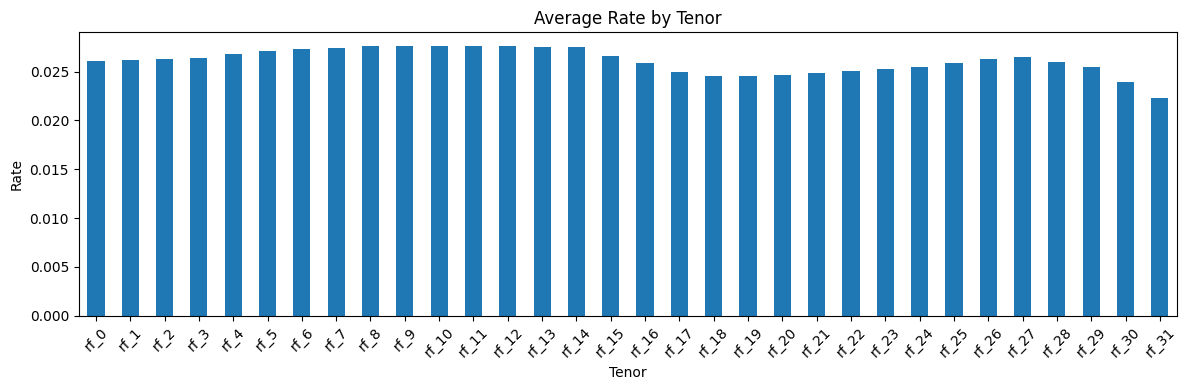

In [8]:

# Interest Rate Analysis
rf_data = df_raw[rf_cols]
rf_missing = rf_data.isnull().sum()
rf_missing_pct = (rf_missing / len(df_raw) * 100).round(2)

print("RF Curve Missing Data:")
print(rf_missing_pct[rf_missing_pct > 0])

plt.figure(figsize=(12, 4))
rf_data.mean().plot(kind='bar')
plt.title('Average Rate by Tenor')
plt.xlabel('Tenor')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:

#  Weekend/Holiday checks
dates = pd.to_datetime(df_raw['date'].unique())
date_df = pd.DataFrame({'date': dates}).sort_values('date')
date_df['weekday'] = date_df['date'].dt.dayofweek
date_df['gap'] = date_df['date'].diff().dt.days

print("Date Analysis:")
print(f"Total dates: {len(dates)}")
print(f"Weekday distribution:\n{date_df['weekday'].value_counts().sort_index()}")
print(f"Has weekends (Sat=5, Sun=6): {(date_df['weekday'] >= 5).any()}")
print(f"Gap distribution:\n{date_df['gap'].value_counts().head()}")


Date Analysis:
Total dates: 1289
Weekday distribution:
weekday
0    241
1    267
2    264
3    259
4    258
Name: count, dtype: int64
Has weekends (Sat=5, Sun=6): False
Gap distribution:
gap
1.0    1000
3.0     229
4.0      38
2.0      18
7.0       1
Name: count, dtype: int64


In [10]:

# build tensors 
df_all = build_full_surface_feature_df("../data/vol_tensor_dataset.csv")
df_all = df_all.dropna()

iv_cols_pivot = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]

maturity_to_tau = {
    '1m': 1/12, '2m': 2/12, '3m': 3/12, '6m': 0.5, '9m': 0.75,
    '1y': 1.0, '18m': 1.5, '2y': 2.0, '3y': 3.0, '4y': 4.0, '5y': 5.0
}

df_aligned = df_raw[df_raw["date"].isin(df_all.index)].copy()
tensors = build_vol_tensors(df_aligned, maturity_to_tau)

tensors_full, X_feat_tensor, df_feat = prepare_surface_and_feature_tensors(
    df_all=df_all,
    df_raw=df_raw,
    feat_cols=feat_cols,
    monthly_interpolation=False
)

print(f"\nTensor shapes:")
print(f"Surface: {tensors_full['surface_tensor'].shape}")
print(f"Features: {X_feat_tensor.shape}")



Tensor shapes:
Surface: torch.Size([1258, 11, 10, 6])
Features: torch.Size([1258, 136])


In [11]:
import importlib
import data.edav
importlib.reload(data.edav)
# Surface Tensor Analysis
from data.edav import analyze_surface_tensor_statistics
surface_analysis = analyze_surface_tensor_statistics(
    tensors_full['surface_tensor'],
    tensors_full['taus'],
    tensors_full['rel_strikes']
)

print("\nSurface Statistics:")
print(f"Overall mean IV: {surface_analysis['overall_mean']:.4f}")
print(f"Overall std IV: {surface_analysis['overall_std']:.4f}")
print("\nMaturity Profiles:")
print(surface_analysis['maturity_profiles'])



Surface Statistics:
Overall mean IV: 0.2259
Overall std IV: 0.0947

Maturity Profiles:
           mean_iv  vol_of_vol  smile_width
tau_0.08  0.311141    0.152087     0.161753
tau_0.17  0.269855    0.122895     0.128106
tau_0.25  0.250793    0.110594     0.108832
tau_0.50  0.225939    0.092949     0.080271
tau_0.75  0.215183    0.083126     0.067440
tau_1.00  0.209621    0.075899     0.059775
tau_1.50  0.203960    0.065722     0.050796
tau_2.00  0.201142    0.059112     0.045710
tau_3.00  0.198477    0.049682     0.038365
tau_4.00  0.198669    0.042719     0.032944
tau_5.00  0.200040    0.037537     0.029001


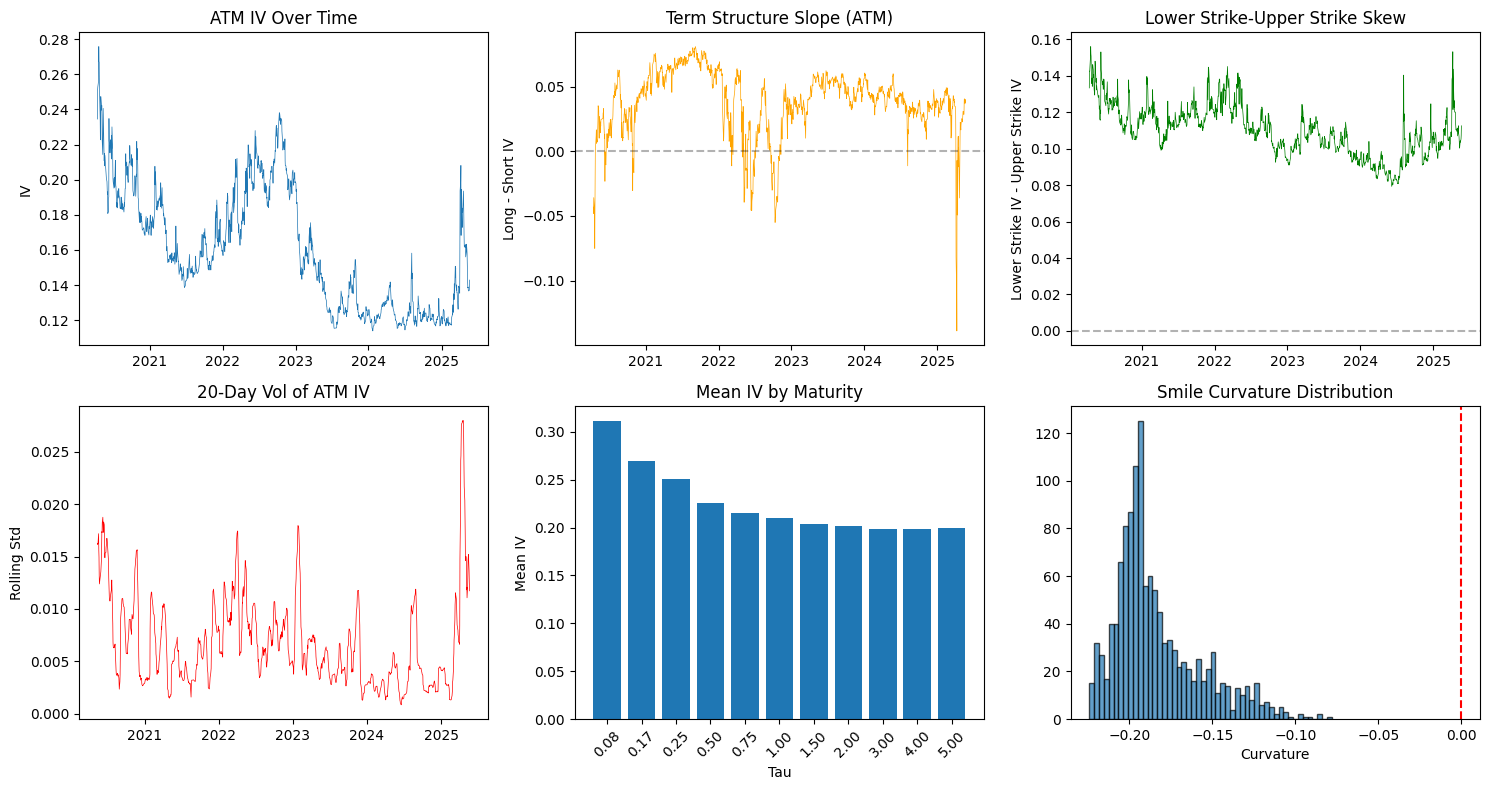

In [12]:


df_stats = visualize_surface_characteristics(
    tensors_full['surface_tensor'],
    tensors_full['taus'],
    tensors_full['rel_strikes'],
    tensors_full['date_tensor']
)


In [13]:

feature_dist = analyze_feature_distributions(df_feat)
print("\nAll 26 Features:")
print(feature_dist)
print("\nTop 5 most variable features:")
print(feature_dist.nlargest(5, 'std')[['mean', 'std', 'skew']])


All 26 Features:
                          mean       std      skew   kurtosis       min  \
log_return            0.000562  0.011470 -0.169753   5.288586 -0.061609   
log_return_ma20       0.000645  0.002256 -0.261537   0.884700 -0.006428   
log_return_z20       -0.030347  0.979826 -0.250218   0.283492 -3.651027   
realized_vol_5d       0.009929  0.006066  2.248135  10.554980  0.000804   
realized_vol_5d_ma20  0.010172  0.005099  2.228614   9.154213  0.003568   
realized_vol_5d_z20  -0.013115  1.156707  0.557272  -0.174310 -2.676229   
rate_0.25y            0.026602  0.023223 -0.076603  -1.842978  0.000040   
rate_0.5y             0.026602  0.023223 -0.076603  -1.842978  0.000040   
rate_1y               0.026703  0.023218 -0.084234  -1.841227  0.000042   
rate_2y               0.026803  0.023213 -0.091267  -1.839687  0.000079   
rate_3y               0.026938  0.023215 -0.100800  -1.837398  0.000110   
rate_4y               0.027327  0.023181 -0.128177  -1.829042  0.000110   
rate_5y

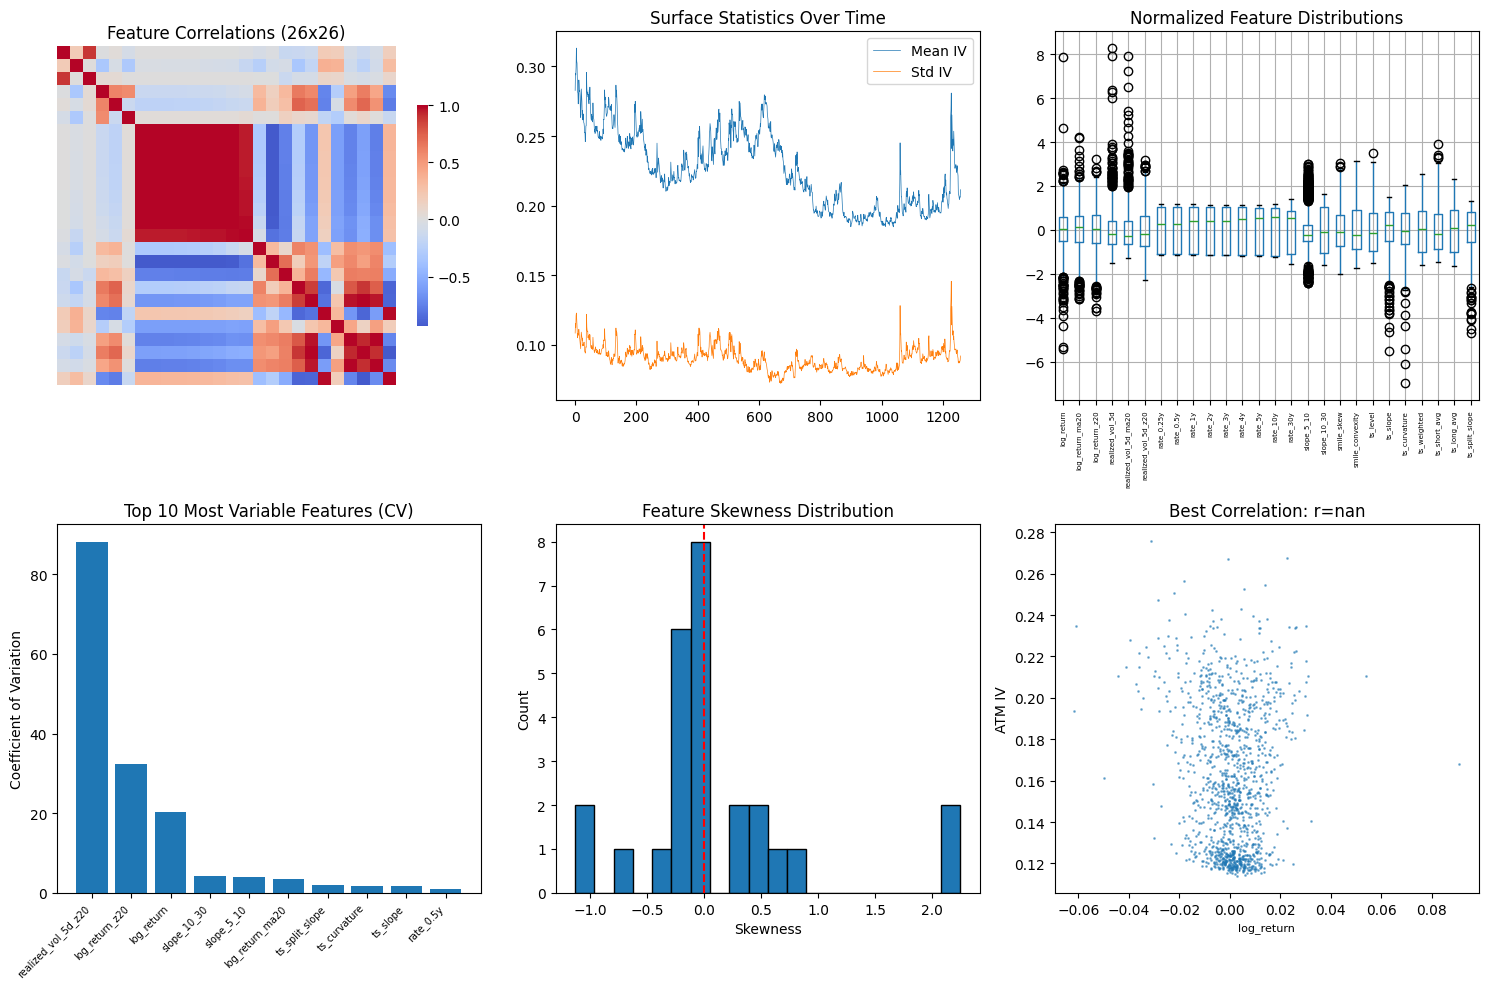


FEATURE ANALYSIS TABLES

1. Feature Statistics Summary:
                        Mean     Std     Min     Max    Skew     Kurt       CV
log_return            0.0006  0.0115 -0.0616  0.0909 -0.1698   5.2886  20.4247
log_return_ma20       0.0006  0.0023 -0.0064  0.0101 -0.2615   0.8847   3.4997
log_return_z20       -0.0303  0.9798 -3.6510  3.1198 -0.2502   0.2835  32.2879
realized_vol_5d       0.0099  0.0061  0.0008  0.0602  2.2481  10.5550   0.6109
realized_vol_5d_ma20  0.0102  0.0051  0.0036  0.0507  2.2286   9.1542   0.5012
realized_vol_5d_z20  -0.0131  1.1567 -2.6762  3.6939  0.5573  -0.1743  88.1995
rate_0.25y            0.0266  0.0232  0.0000  0.0537 -0.0766  -1.8430   0.8730
rate_0.5y             0.0266  0.0232  0.0000  0.0537 -0.0766  -1.8430   0.8730
rate_1y               0.0267  0.0232  0.0000  0.0536 -0.0842  -1.8412   0.8695
rate_2y               0.0268  0.0232  0.0001  0.0536 -0.0913  -1.8397   0.8661
rate_3y               0.0269  0.0232  0.0001  0.0536 -0.1008  -1.8374   0.

In [14]:
importlib.reload(data.edav)
from data.edav import visualize_feature_vs_surface_stats
# Feature vs Surface Comparison
stats_table, correlation_table = visualize_feature_vs_surface_stats(df_feat, df_stats)


In [15]:

# Calendar Arbitrage Check
iv_surfaces = ops.convert_to_numpy(tensors_full['surface_tensor'][:, :, :, -1])
arbitrage_check = check_calendar_arbitrage(iv_surfaces, np.array(tensors_full['taus']))
print(f"\nCalendar Arbitrage Analysis:")
print(f"Total violations: {arbitrage_check['total_violations']}")
print(f"Clean surfaces: {arbitrage_check['clean_surfaces_pct']:.1f}%")



Calendar Arbitrage Analysis:
Total violations: 608
Clean surfaces: 10.0%


In [16]:

# Temporal Analysis
gap_analysis = analyze_temporal_gaps_tensor(tensors_full['date_tensor'])
autocorr_analysis = compute_surface_autocorrelation(tensors_full['surface_tensor'])

print(f"\nTemporal Analysis:")
print(f"Chronological: {gap_analysis['chronological']}")
print(f"Max gap: {gap_analysis['max_gap']} days")
print(f"Mean autocorrelation: {autocorr_analysis['mean_autocorr']:.3f}")



Temporal Analysis:
Chronological: True
Max gap: 12.0 days
Mean autocorrelation: 0.983


In [17]:

#  Set Global Constants
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = len(feat_cols)
LOOKBACK = 20
M, K = SURFACE_SHAPE
BATCH_SIZE = 32
TARGET_DATE = "2025-05-21"


In [18]:

print(f"\nPipeline Configuration:")
print(f"Surface: {M}x{K} = {M*K} points")
print(f"Features: {FEATURE_DIM}")
print(f"Latent: {LATENT_DIM}")


Pipeline Configuration:
Surface: 11x10 = 110 points
Features: 26
Latent: 12


In [19]:
# Maturity Aggregation Impact
importlib.reload(data.edav)
from data.edav import analyze_maturity_aggregation_impact_tensor

aggregation_impact = analyze_maturity_aggregation_impact_tensor(
    tensors_full['surface_tensor'],
    tensors_full['taus'],
    tensors_full['rel_strikes']
)

print("MATURITY AGGREGATION IMPACT:")
print(f"Max information loss feature: {aggregation_impact['max_loss_feature']}")
print(f"Information loss: {aggregation_impact['information_loss_pct'][aggregation_impact['max_loss_feature']]:.1f}%")
print("\nAll losses:")
for feat, loss in aggregation_impact['information_loss_pct'].items():
    print(f"  {feat}: {loss:.1f}%")

MATURITY AGGREGATION IMPACT:
Max information loss feature: convexity
Information loss: 81.9%

All losses:
  skew: 30.7%
  convexity: 81.9%
  atm_level: 10.0%
  mean_iv: 16.2%


In [20]:
importlib.reload(data.edav)
from data.edav import compute_feature_vif
# Cell: Multicollinearity Check
vif_results = compute_feature_vif(df_feat)
print("MULTICOLLINEARITY ANALYSIS:")
print("VIF > 10 indicates problematic multicollinearity")
print(vif_results[vif_results['VIF'] > 10])
print(f"\nHighly correlated features: {len(vif_results[vif_results['VIF'] > 10])}")


MULTICOLLINEARITY ANALYSIS:
VIF > 10 indicates problematic multicollinearity
                 Feature           VIF
13              rate_10y           inf
12               rate_5y           inf
24           ts_long_avg           inf
23          ts_short_avg           inf
19              ts_level           inf
16           slope_10_30           inf
15            slope_5_10           inf
14              rate_30y           inf
25        ts_split_slope           inf
7              rate_0.5y           inf
6             rate_0.25y           inf
22           ts_weighted  1.066168e+06
11               rate_4y  9.818026e+04
9                rate_2y  6.508169e+04
8                rate_1y  4.319144e+04
10               rate_3y  3.994938e+04
20              ts_slope  7.699417e+02
17            smile_skew  2.261388e+02
18       smile_convexity  1.023928e+02
21          ts_curvature  5.899732e+01
4   realized_vol_5d_ma20  2.878211e+01
3        realized_vol_5d  1.992854e+01

Highly correlated feature

In [21]:
#  indices from temporal split
T = tensors_full["surface_tensor"].shape[0]
train_idx, val_idx, test_idx = split_time_series_indices(T, train=0.7, val=0.15)

print(f"Total timesteps: {T}")
print(f"Train indices: {train_idx[0]} to {train_idx[-1]} (n={len(train_idx)})")
print(f"Val indices: {val_idx[0]} to {val_idx[-1]} (n={len(val_idx)})")
print(f"Test indices: {test_idx[0]} to {test_idx[-1]} (n={len(test_idx)})")

#  Slice tensors and analyze distributions
from data.tensor_builder import slice_tensors

train_tensors = slice_tensors(tensors_full, train_idx)
val_tensors = slice_tensors(tensors_full, val_idx)
test_tensors = slice_tensors(tensors_full, test_idx)
importlib.reload(data.edav)
from data.edav import analyze_split_distributions, check_temporal_leakage
# Analyze split distributions
split_analysis = analyze_split_distributions(
    ops.convert_to_numpy(train_tensors['surface_tensor']),
    ops.convert_to_numpy(val_tensors['surface_tensor']),
    ops.convert_to_numpy(test_tensors['surface_tensor'])
)

print("\nTRAIN/VAL/TEST DISTRIBUTION COMPARISON:")
print(f"KS test p-values (>0.05 = similar distributions):")
print(f"  Train vs Val: {split_analysis['train_vs_val'][1]:.4f}")
print(f"  Train vs Test: {split_analysis['train_vs_test'][1]:.4f}")
print(f"  Val vs Test: {split_analysis['val_vs_test'][1]:.4f}")
print("\nSummary statistics:")
for key, val in split_analysis['summary'].items():
    print(f"  {key}: {val:.4f}")

# Check temporal integrity
leakage_check = check_temporal_leakage(train_idx, val_idx, test_idx, lookback=LOOKBACK)
print(f"\nTemporal leakage check (lookback={LOOKBACK}):")
print(f"Safe: {leakage_check['safe_with_lookback']}")
if not leakage_check['safe_with_lookback']:
    for issue in leakage_check['issues']:
        print(f"  WARNING: {issue}")

Total timesteps: 1258
Train indices: 0 to 879 (n=880)
Val indices: 880 to 1068 (n=189)
Test indices: 1069 to 1257 (n=189)

TRAIN/VAL/TEST DISTRIBUTION COMPARISON:
KS test p-values (>0.05 = similar distributions):
  Train vs Val: 0.0000
  Train vs Test: 0.0000
  Val vs Test: 0.0000

Summary statistics:
  train_mean: 0.2373
  val_mean: 0.1925
  test_mean: 0.2061
  train_std: 0.0942
  val_std: 0.0834
  test_std: 0.0967

Temporal leakage check (lookback=20):
Safe: False


,entropy,variance,unique_values,dynamic_range,entropy_change,variance_change
raw_iv,2.780168,0.009503,141790.0,0.966261,NaN,NaN
surface_tensor,2.883388,0.008977,137733.0,0.853152,3.712731,-5.540633
features,0.410940,0.000040,31173.0,0.291690,-85.748020,-99.559608


,Split,Surfaces,Pointwise_Samples,Expansion_Factor
0,Train,860,94600,110
1,Val,189,20790,110
2,Test,189,20790,110


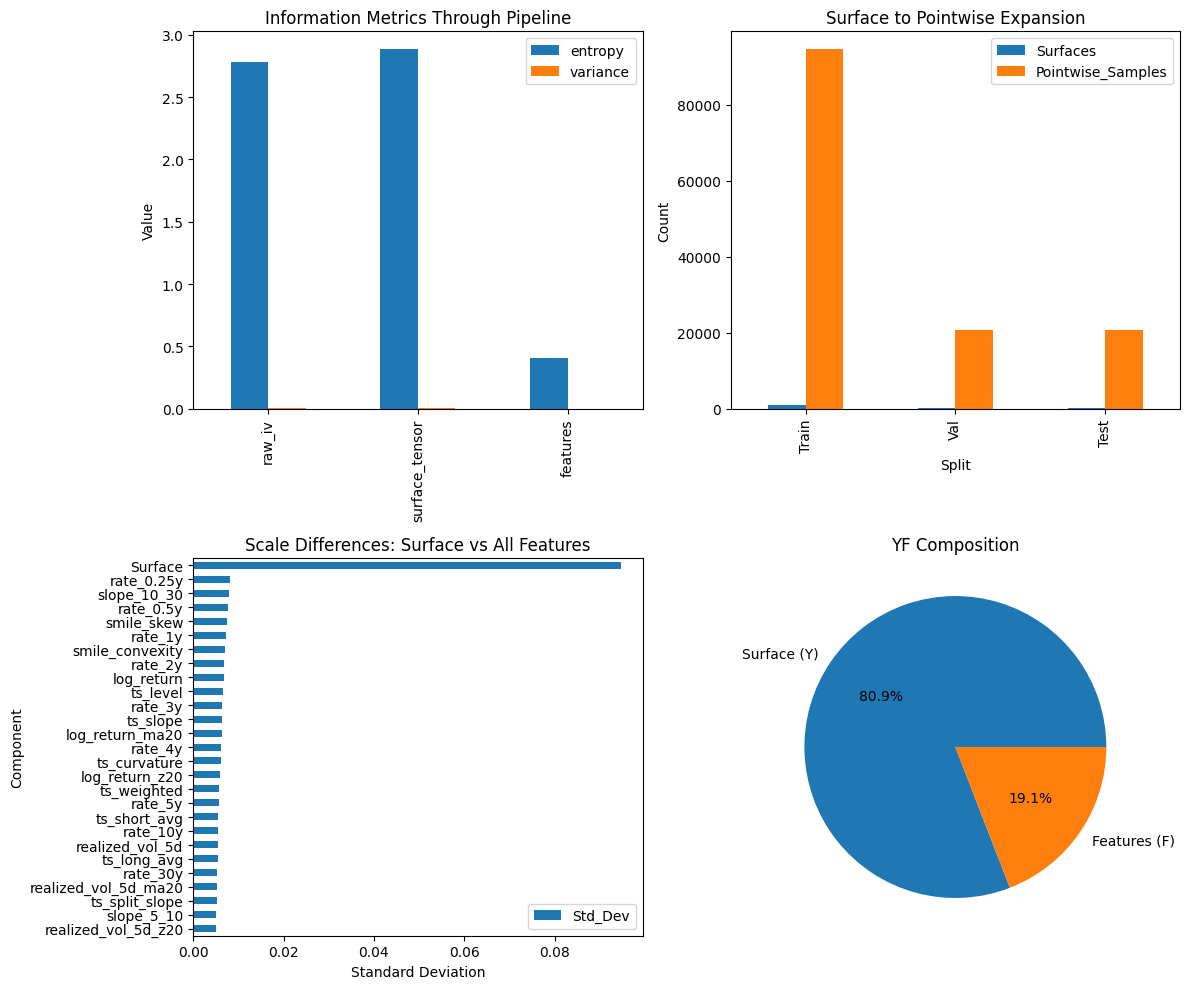

In [22]:
from data.edav import *
#  Pipeline Information Loss Analysis
pipeline_stages = {
  'raw_iv': df_raw['market_iv'].values,
  'surface_tensor': ops.convert_to_numpy(tensors_full['surface_tensor'][:,:,:,-1]).flatten(),
  'features': ops.convert_to_numpy(X_feat_tensor[:, M*K:]).flatten()
}

info_metrics = compare_pipeline_stages(pipeline_stages)
display(info_metrics)

# Pointwise Transformation Analysis
pointwise_analysis = pd.DataFrame({
  'Split': ['Train', 'Val', 'Test'],
  'Surfaces': [len(train_idx)-LOOKBACK, len(val_idx), len(test_idx)],
  'Pointwise_Samples': [(len(train_idx)-LOOKBACK)*M*K, len(val_idx)*M*K, len(test_idx)*M*K],
  'Expansion_Factor': [M*K, M*K, M*K]
})
display(pointwise_analysis)

# Data Structure Impact Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Pipeline information flow
info_metrics[['entropy', 'variance']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Information Metrics Through Pipeline')
axes[0,0].set_ylabel('Value')

# Pointwise expansion
pointwise_analysis.set_index('Split')[['Surfaces', 'Pointwise_Samples']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Surface to Pointwise Expansion')
axes[0,1].set_ylabel('Count')

# Scale comparison - ALL features
surface_std = ops.convert_to_numpy(tensors_full['surface_tensor'][:,:,:,-1]).std()
feature_stds = ops.convert_to_numpy(X_feat_tensor[:, M*K:]).std(axis=0)
scale_df = pd.DataFrame({
  'Component': ['Surface'] + feat_cols,  # ALL features
  'Std_Dev': [surface_std] + list(feature_stds)
})
scale_df_sorted = scale_df.sort_values('Std_Dev', ascending=True)
scale_df_sorted.set_index('Component').plot(kind='barh', ax=axes[1,0])
axes[1,0].set_title('Scale Differences: Surface vs All Features')
axes[1,0].set_xlabel('Standard Deviation')

# Contribution percentages
contribution = pd.DataFrame({
  'Component': ['Surface (Y)', 'Features (F)'],
  'Dimension': [M*K, len(feat_cols)],
  'Percentage': [M*K/(M*K+len(feat_cols))*100, len(feat_cols)/(M*K+len(feat_cols))*100]
})
axes[1,1].pie(contribution['Percentage'], labels=contribution['Component'], autopct='%1.1f%%')
axes[1,1].set_title('YF Composition')

plt.tight_layout()
plt.show()

# Return dataframes for reuse
pipeline_analysis_results = {
  'info_metrics': info_metrics,
  'pointwise': pointwise_analysis,
  'scale': scale_df,
  'contribution': contribution
}

,Method,Avg Smile,Avg Calendar,Clean Surfaces,Max Violations
0,IV Monotonicity,14.303657,65.345787,0,119
1,Total Variance,14.298092,0.000000,0,32


,date,iv_smile,iv_calendar,var_smile,var_calendar,total_iv_method,total_var_method
4,2020-04-21,32,87,32,0,119,32
3,2020-04-20,28,85,28,0,113,28
5,2020-04-22,30,83,30,0,113,30
1,2020-04-15,26,86,26,0,112,26
6,2020-04-23,30,82,30,0,112,30


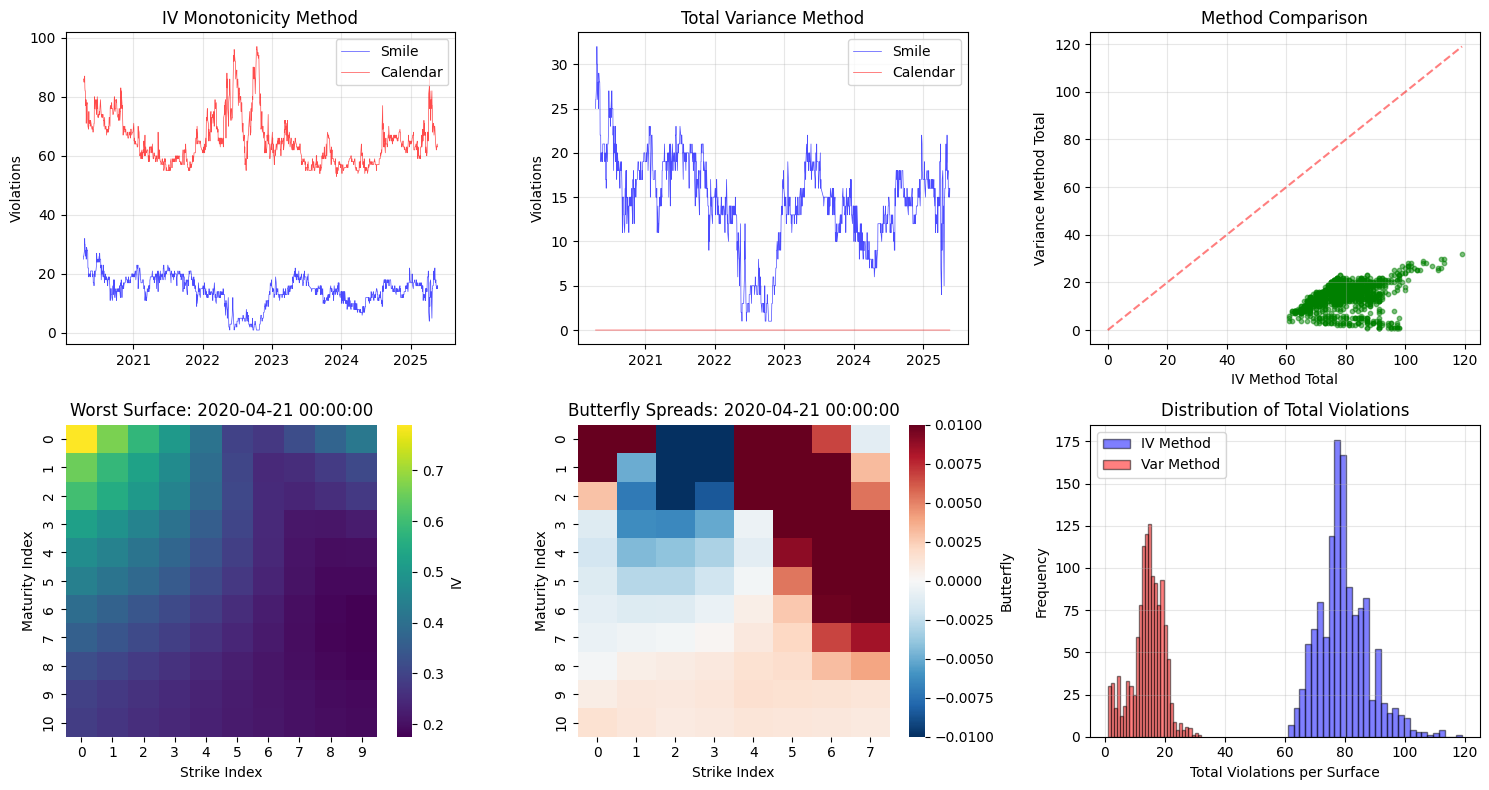

In [23]:
#  Comprehensive Arbitrage Analysis
importlib.reload(data.edav)
from data.edav import check_no_arbitrage_iv_monotonicity, check_no_arbitrage_total_variance

iv_surfaces = ops.convert_to_numpy(tensors_full['surface_tensor'][:, :, :, -1])
taus = np.array(tensors_full['taus'])
strikes = np.array(tensors_full['rel_strikes'])
M, K = len(taus), len(strikes)

# Check violations for all surfaces using BOTH methods
violation_details = []
for t in range(iv_surfaces.shape[0]):
    iv_smile, iv_cal = check_no_arbitrage_iv_monotonicity(iv_surfaces[t], taus, strikes)
    var_smile, var_cal = check_no_arbitrage_total_variance(iv_surfaces[t], taus, strikes, tol=1e-6)
    violation_details.append({
        'date': tensors_full['date_tensor'][t],
        'iv_smile': iv_smile,
        'iv_calendar': iv_cal,
        'var_smile': var_smile,
        'var_calendar': var_cal,
        'total_iv_method': iv_smile + iv_cal,
        'total_var_method': var_smile + var_cal
    })

violations_df = pd.DataFrame(violation_details)

# Summary comparison of both methods
summary = pd.DataFrame({
    'Method': ['IV Monotonicity', 'Total Variance'],
    'Avg Smile': [violations_df['iv_smile'].mean(), violations_df['var_smile'].mean()],
    'Avg Calendar': [violations_df['iv_calendar'].mean(), violations_df['var_calendar'].mean()],
    'Clean Surfaces': [
        ((violations_df['iv_smile'] == 0) & (violations_df['iv_calendar'] == 0)).sum(),
        ((violations_df['var_smile'] == 0) & (violations_df['var_calendar'] == 0)).sum()
    ],
    'Max Violations': [violations_df['total_iv_method'].max(), violations_df['total_var_method'].max()]
})
display(summary)

# Worst 5 surfaces by IV method
worst_dates = violations_df.nlargest(5, 'total_iv_method')[
    ['date', 'iv_smile', 'iv_calendar', 'var_smile', 'var_calendar', 'total_iv_method', 'total_var_method']
]
display(worst_dates)

#  Arbitrage Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# IV Method violations over time
axes[0, 0].plot(pd.to_datetime(violations_df['date']), violations_df['iv_smile'], 
                label='Smile', linewidth=0.5, alpha=0.7, color='blue')
axes[0, 0].plot(pd.to_datetime(violations_df['date']), violations_df['iv_calendar'], 
                label='Calendar', linewidth=0.5, alpha=0.7, color='red')
axes[0, 0].set_title('IV Monotonicity Method')
axes[0, 0].set_ylabel('Violations')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Variance Method violations over time
axes[0, 1].plot(pd.to_datetime(violations_df['date']), violations_df['var_smile'], 
                label='Smile', linewidth=0.5, alpha=0.7, color='blue')
axes[0, 1].plot(pd.to_datetime(violations_df['date']), violations_df['var_calendar'], 
                label='Calendar', linewidth=0.5, alpha=0.7, color='red')
axes[0, 1].set_title('Total Variance Method')
axes[0, 1].set_ylabel('Violations')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Method comparison scatter
axes[0, 2].scatter(violations_df['total_iv_method'], violations_df['total_var_method'], 
                   alpha=0.5, s=10, color='green')
axes[0, 2].plot([0, violations_df['total_iv_method'].max()], 
                [0, violations_df['total_iv_method'].max()], 'r--', alpha=0.5)
axes[0, 2].set_xlabel('IV Method Total')
axes[0, 2].set_ylabel('Variance Method Total')
axes[0, 2].set_title('Method Comparison')
axes[0, 2].grid(True, alpha=0.3)

# Worst surface heatmap
worst_idx = violations_df['total_iv_method'].idxmax()
worst_surface = iv_surfaces[worst_idx]
worst_date = violations_df.loc[worst_idx, 'date']

sns.heatmap(worst_surface, cmap='viridis', ax=axes[1, 0], cbar_kws={'label': 'IV'})
axes[1, 0].set_title(f'Worst Surface: {worst_date}')
axes[1, 0].set_xlabel('Strike Index')
axes[1, 0].set_ylabel('Maturity Index')

# Butterfly spread for worst surface
butterfly_grid = np.zeros((M, K-2))
for i in range(M):
    for j in range(1, K-1):
        butterfly_grid[i, j-1] = worst_surface[i, j+1] - 2*worst_surface[i, j] + worst_surface[i, j-1]

sns.heatmap(butterfly_grid, cmap='RdBu_r', center=0, ax=axes[1, 1], 
            cbar_kws={'label': 'Butterfly'}, vmin=-0.01, vmax=0.01)
axes[1, 1].set_title(f'Butterfly Spreads: {worst_date}')
axes[1, 1].set_xlabel('Strike Index')
axes[1, 1].set_ylabel('Maturity Index')

# Distribution comparison
axes[1, 2].hist(violations_df['total_iv_method'], bins=30, alpha=0.5, 
                label='IV Method', color='blue', edgecolor='black')
axes[1, 2].hist(violations_df['total_var_method'], bins=30, alpha=0.5, 
                label='Var Method', color='red', edgecolor='black')
axes[1, 2].set_xlabel('Total Violations per Surface')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Distribution of Total Violations')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

arbitrage_results = violations_df


arbitrage analysis for 2020-04-21
iv monotonicity method: smile=32, calendar=87, total=119
total variance method: smile=32, calendar=0, total=32
significant (>0.005): smile=10, calendar=76

calendar check: term structure at strike 1.10
  maturity         iv    total var    iv diff     var diff
    0.0833     0.2960     0.007302     0.0000     0.000000
    0.1667     0.3035     0.015356     0.0075     0.008054
    0.2500     0.3086     0.023811     0.0051     0.008455
    0.5000     0.3021     0.045625    -0.0065     0.021814 <- calendar violation
    0.7500     0.2897     0.062949    -0.0124     0.017323 <- calendar violation
    1.0000     0.2758     0.076065    -0.0139     0.013116 <- calendar violation
    1.5000     0.2545     0.097130    -0.0213     0.021065 <- calendar violation
    2.0000     0.2408     0.115981    -0.0137     0.018851 <- calendar violation
    3.0000     0.2270     0.154585    -0.0138     0.038604 <- calendar violation
    4.0000     0.2220     0.197072    -0.

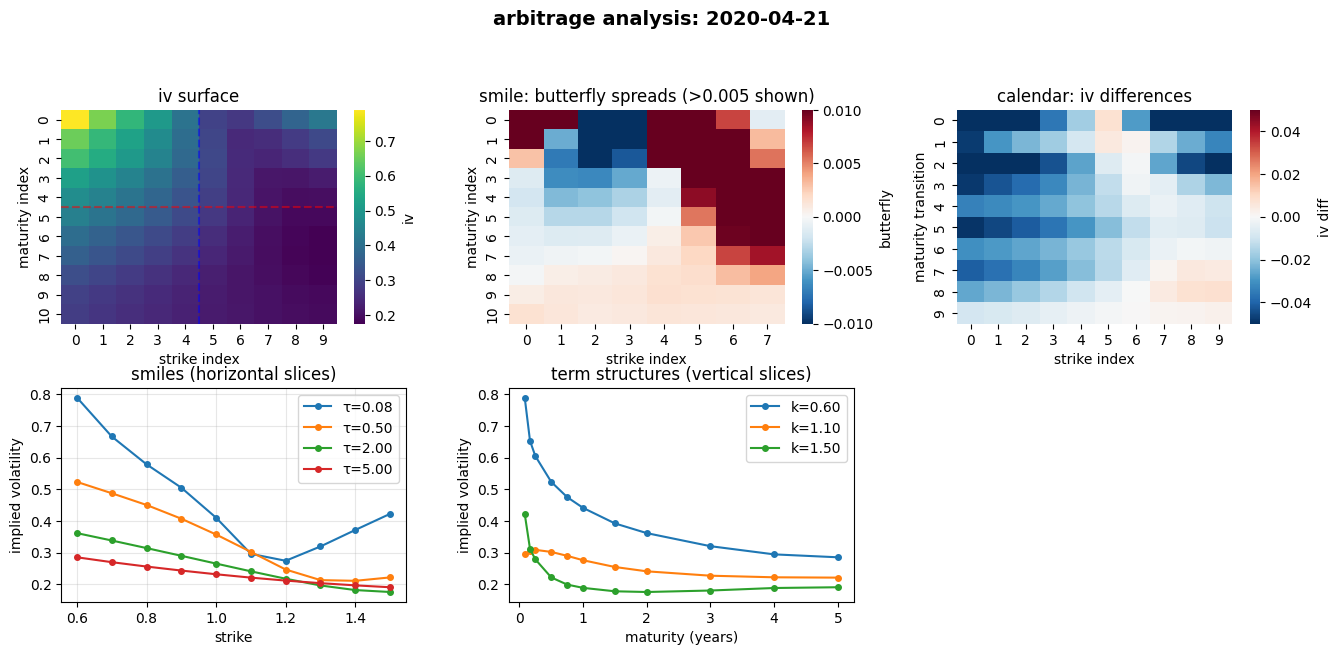

In [24]:
# single date arbitrage analysis with tolerance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from data.edav import check_no_arbitrage_iv_monotonicity, check_no_arbitrage_total_variance

# set date and tolerance
analysis_date = "2020-04-21"
tolerance = 0.005  # 0.5% iv tolerance for significant violations

# convert to datetime for comparison
target_date = pd.to_datetime(analysis_date)

# find the index for this date
date_idx = None
for idx, date in enumerate(tensors_full['date_tensor']):
   if pd.to_datetime(date) == target_date:
       date_idx = idx
       break

if date_idx is None:
   print(f"date {analysis_date} not found in dataset")
   print(f"available date range: {tensors_full['date_tensor'][0]} to {tensors_full['date_tensor'][-1]}")
else:
   # get surface for this date
   surface = iv_surfaces[date_idx]
   M, K = surface.shape
   
   # run arbitrage checks with both methods
   iv_smile, iv_cal = check_no_arbitrage_iv_monotonicity(surface, taus, strikes)
   var_smile, var_cal = check_no_arbitrage_total_variance(surface, taus, strikes, tol=1e-5)
   
   # count significant violations with tolerance
   smile_violations_significant = 0
   calendar_violations_significant = 0
   
   for i in range(M):
       for j in range(1, K-1):
           butterfly = surface[i, j+1] - 2*surface[i, j] + surface[i, j-1]
           if butterfly < -tolerance:
               smile_violations_significant += 1
   
   for j in range(K):
       for i in range(1, M):
           iv_diff = surface[i, j] - surface[i-1, j]
           if iv_diff < -tolerance:
               calendar_violations_significant += 1
   
   print(f"\narbitrage analysis for {analysis_date}")
   print(f"iv monotonicity method: smile={iv_smile}, calendar={iv_cal}, total={iv_smile + iv_cal}")
   print(f"total variance method: smile={var_smile}, calendar={var_cal}, total={var_smile + var_cal}")
   print(f"significant (>{tolerance}): smile={smile_violations_significant}, calendar={calendar_violations_significant}")
   
   # calendar check: term structure at middle strike
   strike_idx = K // 2
   print(f"\ncalendar check: term structure at strike {strikes[strike_idx]:.2f}")
   print(f"{'maturity':>10} {'iv':>10} {'total var':>12} {'iv diff':>10} {'var diff':>12}")
   
   calendar_viol_count = 0
   for i in range(M):
       iv = surface[i, strike_idx]
       total_var = iv**2 * taus[i]
       iv_diff = iv - surface[i-1, strike_idx] if i > 0 else 0
       var_diff = total_var - (surface[i-1, strike_idx]**2 * taus[i-1]) if i > 0 else 0
       
       violation_marker = ""
       if i > 0 and iv_diff < -tolerance:
           violation_marker = " <- calendar violation"
           calendar_viol_count += 1
       
       print(f"{taus[i]:10.4f} {iv:10.4f} {total_var:12.6f} {iv_diff:10.4f} {var_diff:12.6f}{violation_marker}")
   
   # smile check: butterfly spreads at 1-year maturity
   maturity_idx = min(5, M-1)
   print(f"\nsmile check: butterfly spreads at τ={taus[maturity_idx]:.2f} year")
   
   butterfly_violations = []
   for j in range(1, K-1):
       left = surface[maturity_idx, j-1]
       center = surface[maturity_idx, j]
       right = surface[maturity_idx, j+1]
       butterfly = right - 2*center + left
       
       if abs(butterfly) > tolerance:  # only show significant values
           valid = butterfly >= 0
           if not valid:
               butterfly_violations.append((strikes[j], butterfly))
           print(f"strike {strikes[j]:5.2f}: butterfly={butterfly:9.6f} {'ok' if valid else 'violation'}")
   
   # visualization
   fig = plt.figure(figsize=(16, 10))
   gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
   fig.suptitle(f'arbitrage analysis: {analysis_date}', fontsize=14, fontweight='bold')
   
   # row 1: surface views
   ax1 = fig.add_subplot(gs[0, 0])
   sns.heatmap(surface, cmap='viridis', ax=ax1, cbar_kws={'label': 'iv'})
   ax1.set_title('iv surface')
   ax1.set_xlabel('strike index')
   ax1.set_ylabel('maturity index')
   ax1.axhline(y=maturity_idx, color='red', linestyle='--', alpha=0.5)
   ax1.axvline(x=strike_idx, color='blue', linestyle='--', alpha=0.5)
   
   ax2 = fig.add_subplot(gs[0, 1])
   butterfly_grid = np.zeros((M, K-2))
   for i in range(M):
       for j in range(1, K-1):
           butterfly = surface[i, j+1] - 2*surface[i, j] + surface[i, j-1]
           butterfly_grid[i, j-1] = butterfly
   
   butterfly_mask = np.abs(butterfly_grid) < tolerance
   butterfly_display = np.ma.masked_where(butterfly_mask, butterfly_grid)
   
   sns.heatmap(butterfly_display, cmap='RdBu_r', center=0, ax=ax2,
               cbar_kws={'label': 'butterfly'}, vmin=-0.01, vmax=0.01)
   ax2.set_title(f'smile: butterfly spreads (>{tolerance} shown)')
   ax2.set_xlabel('strike index')
   ax2.set_ylabel('maturity index')
   
   ax3 = fig.add_subplot(gs[0, 2])
   calendar_grid = np.zeros((M-1, K))
   for i in range(M-1):
       for j in range(K):
           calendar_grid[i, j] = surface[i+1, j] - surface[i, j]
   
   sns.heatmap(calendar_grid, cmap='RdBu_r', center=0, ax=ax3,
               cbar_kws={'label': 'iv diff'}, vmin=-0.05, vmax=0.05)
   ax3.set_title('calendar: iv differences')
   ax3.set_xlabel('strike index')
   ax3.set_ylabel('maturity transition')
   
   # row 2: slices
   ax4 = fig.add_subplot(gs[1, 0])
   for i in [0, M//3, 2*M//3, M-1]:
       ax4.plot(strikes, surface[i, :], 'o-', label=f'τ={taus[i]:.2f}', markersize=4)
   ax4.set_xlabel('strike')
   ax4.set_ylabel('implied volatility')
   ax4.set_title('smiles (horizontal slices)')
   ax4.legend()
   ax4.grid(True, alpha=0.3)
   
   ax5 = fig.add_subplot(gs[1, 1])
   for k in [0, K//2, K-1]:
       ax5.plot(taus, surface[:, k], 'o-', label=f'k={strikes[k]:.2f}', markersize=4)
   ax5.set_xlabel('maturity (years)')
   ax5.set_ylabel('implied volatility')
   ax5.set_title('term structures (vertical slices)')
   ax5.legend()
   ax5